In [1]:
# Import all necessary libraries
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import applications
from tensorflow.keras.regularizers import l2, l1

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 27.9 MB/s 
     |████████████████████████████████| 596 kB 51.2 MB/s 
     |████████████████████████████████| 6.6 MB 49.9 MB/s 
     |████████████████████████████████| 101 kB 8.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import transformers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import the training and test .csv files
import pandas as pd
colnames=['image_path', 'text', 'food']
train = pd.read_csv('/content/drive/MyDrive/Fusion/train_titles.csv', names=colnames, header=None, sep = ',', index_col=['image_path'])
test = pd.read_csv('/content/drive/MyDrive/Fusion/test_titles.csv', names=colnames, header=None, sep = ',', index_col=['image_path'])
print(test.shape[0])

1375


In [6]:
# Sort values by 'image_path'
test = test.sort_values('image_path')
print(test.shape[0])
train = train.sort_values('image_path')

1375


In [7]:
import numpy as np 
import glob
import os

def get_missing(file, df):
  parts = file.split(os.sep)
  #print(parts)
  idx = parts[-1]
  #print(idx)
  cls = parts[-2]  
  #print(cls)
  indexes = df[:,0]
  #print(indexes)
  classes = df[:,2]
  #print(classes)
  
 
  if idx in indexes:
    text = df[idx == indexes][0,1]
    return pd.NA, pd.NA, pd.NA
  
  else:
    text = df[cls == classes][:,1]
    return idx, text, cls   
  #print(idx)
vec_get_missing = np.vectorize(get_missing, signature='(),(m,n)->(),(),()')  

In [8]:
# Function for images loading
from sklearn.utils import shuffle

def add_not_found(path, df):
  files = glob.glob(path)
  df = df.reset_index()
  idxs, texts, cls = vec_get_missing(files, df.values)
  #print(df.values)
  found = pd.DataFrame({"text": texts,
                        "food": cls,
                       "image_path": idxs})
  #print(idxs)
  na = found.isna().sum().values[0]
 # print(na)
  if na<found.shape[0]:
    df = df.append(found)
  df = df.drop_duplicates(subset='image_path', keep='first').dropna()
  df = df.set_index('image_path')
  df = shuffle(df, random_state = 0)
  return df      

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Fusion/Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

testing_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Fusion/Dataset/test',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 4117 images belonging to 6 classes.
Found 1375 images belonging to 6 classes.


In [11]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [12]:
nClasses = train.food.nunique()

In [13]:
MAX_LEN= 50

In [14]:
# Preprocessing of texts according to BERT +
# Cleaning of the texts
import urllib.request
import re
import numpy as np
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sentence.lower()
    return sentence

def remove_tags(text):
    return TAG_RE.sub('', text)

TAG_RE = re.compile(r'<[^>]+>')
vec_preprocess_text = np.vectorize(preprocess_text)

def get_tokens(text, tokenizer):
  tokens = tokenizer.tokenize(text)
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  length = len(tokens)
  if length > max_length:
      tokens = tokens[:max_length]
  return tokens, length  

def get_masks(text, tokenizer, max_length):
    """Mask for padding"""
    tokens, length = get_tokens(text, tokenizer)
    return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))
vec_get_masks = np.vectorize(get_masks, signature = '(),(),()->(n)')

def get_segments(text, tokenizer, max_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    tokens, length = get_tokens(text, tokenizer)
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))
vec_get_segments = np.vectorize(get_segments, signature = '(),(),()->(n)')

def get_ids(text, tokenizer, max_length):
    """Token ids from Tokenizer vocab"""
    tokens, length = get_tokens(text, tokenizer)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length-length))
    return input_ids
vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')

def get_texts(path):
    path = path.decode('utf-8')
    parts = path.split(os.sep)
    image_name = parts[-1]
    is_train = parts[-3] == 'train'
    #print(train)
    if is_train:
      df = train
    else:
      df = test

    text = df['text'][image_name]
    return text

vec_get_text = np.vectorize(get_texts)
def prepare_text(paths):
    #Preparing texts
    
    texts = vec_get_text(paths)
    
    text_array = vec_preprocess_text(texts)
    ids = vec_get_ids(text_array, 
                      tokenizer, 
                      max_length).squeeze().astype(np.int32)
    masks = vec_get_masks(text_array,
                          tokenizer,
                          max_length).squeeze().astype(np.int32)
    segments = vec_get_segments(text_array,
                                tokenizer,
                                max_length).squeeze().astype(np.int32)
    
    return ids, segments, masks

def clean(i, tokens):
  try:
    this_token = tokens[i]
    next_token = tokens[i+1]
  except:
    return tokens
  if '##' in next_token:
      tokens.remove(next_token)
      tokens[i] = this_token + next_token[2:]
      tokens = clean(i, tokens)
      return tokens
  else:
    i = i+1
    tokens = clean(i, tokens)
    return tokens

def clean_text(array):
  array = array[(array!=0) & (array != 101) & (array != 102)]
  tokens = tokenizer.convert_ids_to_tokens(array)
  tokens = clean(0, tokens)
  text = ' '.join(tokens)
  return text

In [15]:
# Images preprocessing
import cv2
def load_image(path):
    path = path.decode('utf-8')
    image = cv2.imread(path)
    image = cv2.resize(image, (img_width, img_height))
    image = image/255
    #print(type(image))
    image = image.astype(np.float32)
    parts = path.split(os.sep)
    labels = parts[-2] == Classes 
    labels = labels.astype(np.int32)
    
    return image, labels
    
vec_load_image = np.vectorize(load_image, signature = '()->(r,c,d),(s)')

In [16]:
# Dataset creation

def prepare_data(paths):
    #Images and labels
    images, labels = tf.numpy_function(vec_load_image, 
                                      [paths], 
                                      [tf.float32, 
                                        tf.int32])   
    
    
    [ids, segments, masks, ] = tf.numpy_function(prepare_text, 
                                              [paths], 
                                              [tf.int32, 
                                               tf.int32,
                                               tf.int32])
    images.set_shape([None, img_width, img_height, depth])
    labels.set_shape([None, nClasses])
    ids.set_shape([None, max_length])
    masks.set_shape([None, max_length])
    segments.set_shape([None, max_length])
    return ({"input_word_ids": ids, 
             "input_mask": masks,  
             "segment_ids": segments, 
             "image": images},
            {"class": labels})
    

    return dataset

In [17]:
# Parameters setting: images width and height, depth, number if classes, input shape
#batch_size =  80
batch_size= 32
img_width = 224
img_height = 224
depth = 3
max_length = 50 #Setup according to the text
n=test.food.unique()
print(n)
nClasses = train.food.nunique()
print(nClasses)
Classes = train.food.unique()
print(Classes)
input_shape = (img_width, img_height, depth)

['apple_pie' 'carrot_cake' 'cheesecake' 'club_sandwich' 'falafel'
 'grilled_cheese_sandwich']
6
['apple_pie' 'carrot_cake' 'cheesecake' 'club_sandwich' 'falafel'
 'grilled_cheese_sandwich']


In [18]:
# Images loading using tf.data
def tf_data(path, batch_size):
    paths = tf.data.Dataset.list_files(path)
    paths = paths.batch(64)
    dataset = paths.map(prepare_data, tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.unbatch()
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    return dataset   
data_train = tf_data('/content/drive/MyDrive/Fusion/Dataset/train/*/*.jpg', batch_size)
data_test = tf_data('/content/drive/MyDrive/Fusion/Dataset/test/*/*.jpg', batch_size)
#os.listdir('d:/Work Station/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs/Images/train')

In [19]:
import keras,os
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from tensorflow.keras.layers import Input,Lambda,Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from glob import glob
import numpy as np

In [20]:
vgg16 = VGG16(input_shape=[224,224]+ [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [21]:
for layer in vgg16.layers:
  layer.trainable=True

In [22]:
x= Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
prediction = Dense(6, activation ='softmax')(x)

In [23]:
from tensorflow.keras.models import Model
model_vgg = Model(inputs=vgg16.input, outputs= prediction)

In [24]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
model_vgg.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

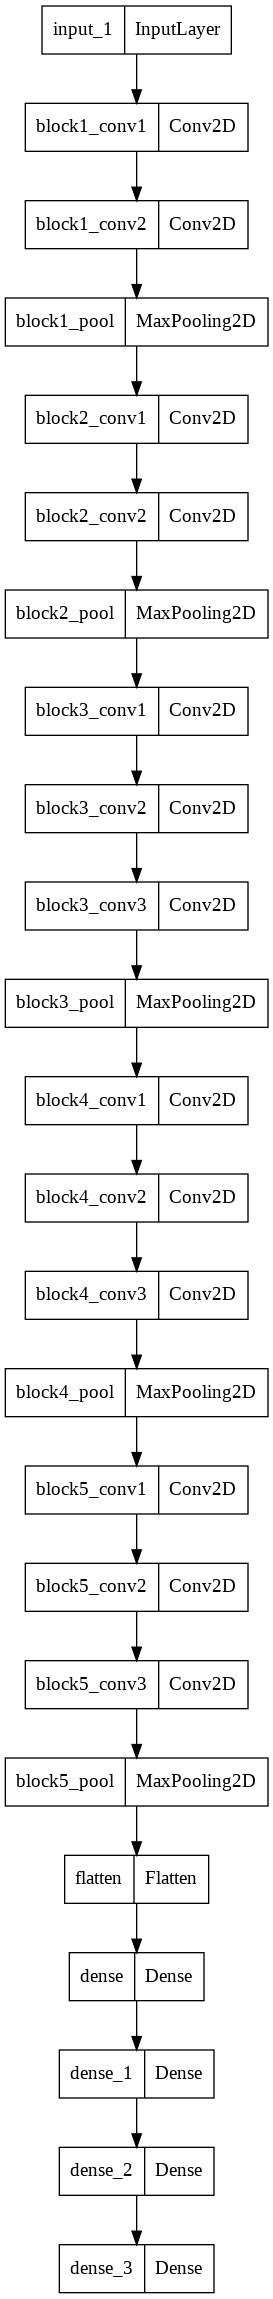

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model_vgg, to_file='model_vgc.png')

In [28]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
segment_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='segment_ids')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
x = roberta_model([input_word_ids,input_mask,segment_ids])
x = x[0]
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(6, activation='softmax')(x)
model_roberta = tf.keras.Model(inputs=[input_word_ids,input_mask,segment_ids], outputs=[x])

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [29]:
for layer in model_roberta.layers:
    layer.trainable = True

In [30]:
model_roberta.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_mask[0][0]',       

In [31]:
model_roberta.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

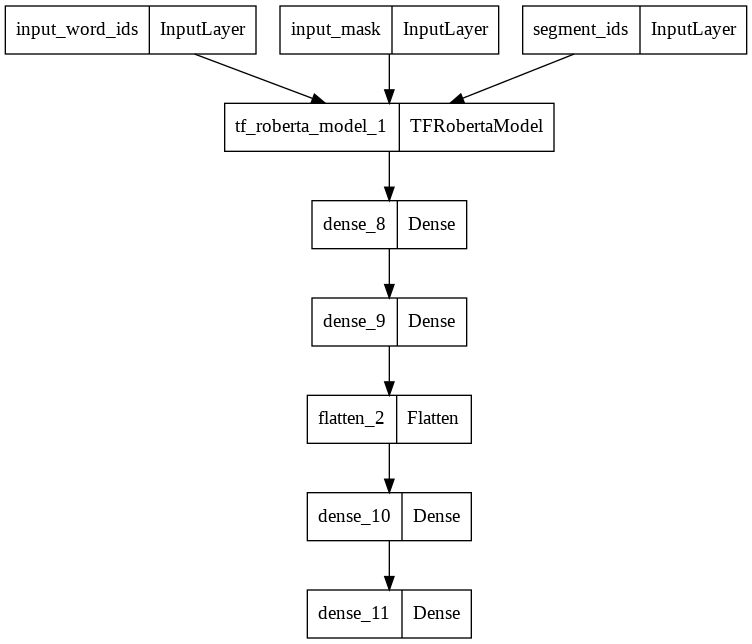

In [32]:
plot_model(model_roberta, to_file='bert_roberta.png')

In [33]:
# Stacking early-fusion multimodal model

input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                    name="segment_ids")
image_input = layers.Input(shape = input_shape, dtype=tf.float32,
                           name = "image")

image_side = model_vgg(image_input)
text_side = model_roberta([input_word_ids, input_mask, segment_ids])
# Concatenate features from images and texts
merged = layers.Concatenate()([image_side, text_side])
output = layers.Dense(nClasses, activation='softmax', name = "class")(merged)

In [34]:
model_combined= models.Model([input_word_ids, input_mask, segment_ids, image_input], output)

In [35]:
model_combined.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 50)]         0           []                         

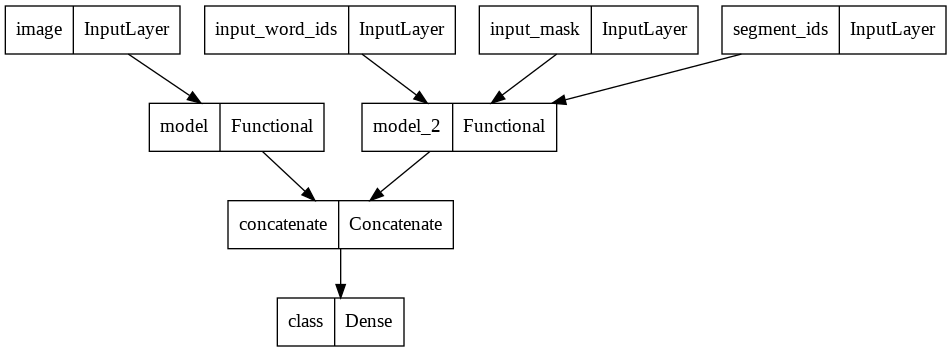

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(model_combined, to_file='multimodal_RoBERTa+VGC16.png')

In [37]:
# Stochastic Gradient Descent optimizer
sgd = optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=False)

# Compile model
model_combined.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=['accuracy'])

In [38]:
# Setup callbacks, logs and early stopping condition
import keras
from keras import callbacks
import numpy as np
import h5py
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
checkpoint_path = "stacking_early_fusion.weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
#checkpoint_path= "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
cp = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy',save_best_only=True, save_weights_only=True, verbose=1, mode='max')
print(cp)
csv_logger = callbacks.CSVLogger('StackingEarlyFusion.log')
print(csv_logger)
es = callbacks.EarlyStopping(patience = 3, restore_best_weights=True)

In [39]:
#Reduce learning rate if no improvement is observed
from keras.callbacks import ReduceLROnPlateau
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.00001)

In [40]:
# Training
history = model_combined.fit(data_train,
                    epochs=10,
                    steps_per_epoch = train.shape[0] //batch_size,
                    validation_data = data_test,
                    validation_steps = test.shape[0] //batch_size,
                    callbacks=[cp, csv_logger, reduce_lr])

Epoch 1/10
128/128 [==============================] - ETA: 0s - loss: 1.7984 - accuracy: 0.1685
Epoch 1: val_accuracy improved from -inf to 0.16815, saving model to stacking_early_fusion.weights-improvement-01-0.17.hdf5
128/128 [==============================] - 1846s 14s/step - loss: 1.7984 - accuracy: 0.1685 - val_loss: 1.7904 - val_accuracy: 0.1682 - lr: 1.0000e-04
Epoch 2/10
128/128 [==============================] - ETA: 0s - loss: 1.7820 - accuracy: 0.1804
Epoch 2: val_accuracy improved from 0.16815 to 0.18824, saving model to stacking_early_fusion.weights-improvement-02-0.19.hdf5
128/128 [==============================] - 125s 937ms/step - loss: 1.7820 - accuracy: 0.1804 - val_loss: 1.7736 - val_accuracy: 0.1882 - lr: 1.0000e-04
Epoch 3/10
128/128 [==============================] - ETA: 0s - loss: 1.7551 - accuracy: 0.2311
Epoch 3: val_accuracy improved from 0.18824 to 0.30729, saving model to stacking_early_fusion.weights-improvement-03-0.31.hdf5
128/128 [======================